## Seismic time-slice multi-attribute co-rendering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
% matplotlib inline

Let's load two time slices from disk. The first one is a time slice of the seismic amplitudes, the second is a time slice from a continuity attribute. Continuity is also sometimes referred to as similarity, variance, or coherence. These are edge-detection type attributes that are useful for looking for faults, fractures, and other discontinuities in the data.

In [2]:
A = np.load('data/amp_slice.npy')
B = np.load('data/cont.npy')

In [3]:
# This is just a function to scale the amplitudes between 0-1
vmin = -0.75*A.ptp() # make axis 50% larger than max/min of trace
vmax = 0.75*A.ptp()
Anorm = 0.5 + (A / vmax)
Anorn = np.clip(Anorm,0,1)

In [4]:
# Let's use the 'RdBu' colormap for seismic
img_array = plt.get_cmap('RdBu')(Anorm)

Let's plot the data. In the first panel, we'll plot the amplitudes. In the second panel, we'll plot the continuity attribute, in the third panel we'll set the continuity image to 75% opacity, and lay it ontop of the amplitudes to see both data in the same space.

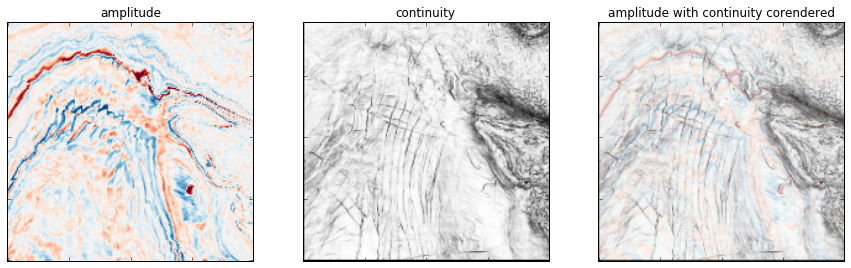

In [8]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('amplitude')
ax1.imshow(img_array,origin='bottom')
ax1.set_xticklabels([])
ax1.set_yticklabels([])

ax2.set_title('continuity')
ax2.imshow(B, cmap='Greys_r', origin='bottom')
ax2.set_xticklabels([])
ax2.set_yticklabels([])

ax3.set_title('amplitude with continuity corendered')
ax3.imshow(img_array, cmap='coolwarm_r', origin='bottom')
ax3.imshow(B, cmap='Greys_r',alpha=0.75, origin='bottom')
ax3.set_xticklabels([])
ax3.set_yticklabels([])

fig.savefig('Amp_Cont_3panel.PNG')

But this presentation isn't ideal. It looks washed out. Let's try modulating the lightness in the seismic amplitude image by using the continuity. 

In order to change the lightness of the colourmap, we need to convert the the red, green, blue (RGB) triplets of the image into hue, saturation, and value (HSV) triplets first. Then we can multiply the "value" channel by the continuity (which already fortuitously has a range between 0 and 1.0).

In order to convert an image of RGB triplets into HSV, and vice versa, we need to import two new functions from the matplotlib.colors module,

In [9]:
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

In [10]:
# Modulate lightness with Continuity
hsv = rgb_to_hsv(img_array[:,:,:3])
hsv[:, :, 2] *= B
new = hsv_to_rgb(hsv)

Let's remake our plot

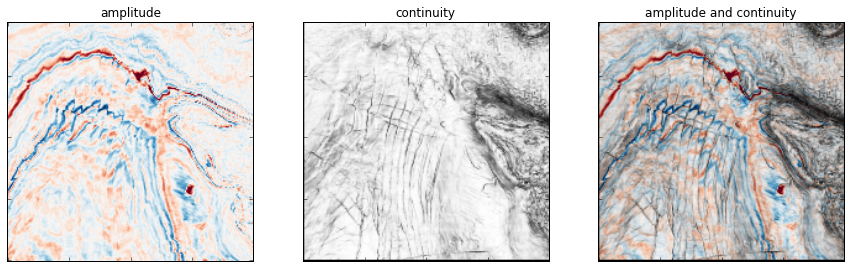

In [33]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('amplitude')
ax1.imshow(img_array, origin='bottom')
ax1.set_xticklabels([])
ax1.set_yticklabels([])

ax2.set_title('continuity')
ax2.imshow(B, cmap='Greys_r', origin='bottom')
ax2.set_xticklabels([])
ax2.set_yticklabels([])

# Display blend

ax3.set_title('amplitude and continuity')
ax3.imshow(new,  origin='bottom')
ax3.set_xticklabels([])
ax3.set_yticklabels([])

fig.savefig('Amp_Cont_3panel_better.PNG')

### Make a 2D colormap to put as a legend

In order to make a 2D colourmap to place as our legend, we need to import the makeMappingArray function from the matplotlib.colors module. We'll also import all the colormaps (called cm) that matplotlib has to offer, so you can try this out with any one of the built in colour maps.

For a list of all the default colormaps, see http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps (Remember, to reverse the direction of any of these colourmaps, simply append an "_r" to the name when you call it.

In [12]:
from matplotlib import cm
from matplotlib.colors import makeMappingArray

Choose a colour map from Matplotlib's list of standard colourmaps.

In [13]:
seisbar = cm.get_cmap('RdBu')

Let's make an colourmap array that has 32 colours in it. This number can be any number you like. We probably wouldn't see much difference for any more than 64 colours, if the colour map is smoothly varying.

In [14]:
ncolours = 32
seis_array = makeMappingArray(ncolours, seisbar)

seis_array is an RGBA representation of our colourmap. But it's has the shape,

In [15]:
np.shape(seis_array)

(32, 4)

So we need to change the shape of the array, by adding an dimension to it. We can also drop the A (alpha) channel, because we aren't going to be using that,

In [16]:
color_arr = seis_array[np.newaxis,:]  
color_arr = color_arr[:,:,:-1]

Now, we can build out a square image for plotting (32 x 32 x 3) using NumPy's tile function,

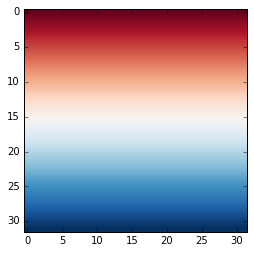

In [17]:
colour_roll = np.rollaxis(color_arr,1)
seis_rgb_mtx = np.tile(colour_roll,(32,1))
np.shape(seis_rgb_mtx)
plt.imshow(seis_rgb_mtx)

Since Matplotlib uses RGB to diplay graphics, passing the HSV representation to the plot looks incorrect. But, now that we have an HSV representation of our colourmap, we are ready to modulate the lightness values across the image

In [18]:
seis_hsv = rgb_to_hsv(seis_rgb_mtx)

In [19]:
# Create a ramp of lightness that goes from 0 to 1 along the horizontal axis of the colormap
hues, lightness = np.mgrid[0:1:32j, 0:1.0:32j]
# modulate "values" in last slice,
seis_hsv[:,:,2] *= lightness

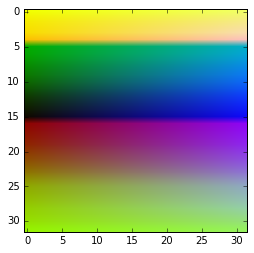

In [20]:
# convert RGB matrix to HSV matrix
plt.imshow(seis_hsv)

But in order to render out modified image we need to conver the triplets back into RGB format,

In [21]:
RGB = hsv_to_rgb(seis_hsv)

In [22]:
def plot_annot(ax, text1='attribute 1', text2='attribute 2'):
    """ A helper function to label the axes, to save typing """    
    ax.set_ylabel(text1, rotation=0, ha='left',va='center')
    ax.yaxis.set_label_coords(1.025, 0.5)
    ax.yaxis.tick_right()
    ax.set_xlabel(text2)
    ax.set_xticklabels(['','low','','','high',''])
    ax.set_yticklabels(['','neg.','','','pos.',''])
    return

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:391: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


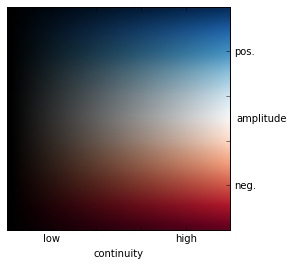

In [23]:
# Make figure
fig = plt.figure(figsize = (4,5))
ax = fig.add_subplot(111,axisbg='k')
ax.imshow(RGB, origin="lower", extent=[0, 1, 0, 1])
plot_annot(ax, 'amplitude', 'continuity')
fig.savefig('Amp_Cont_2D_colormap.PNG')
fig.show()

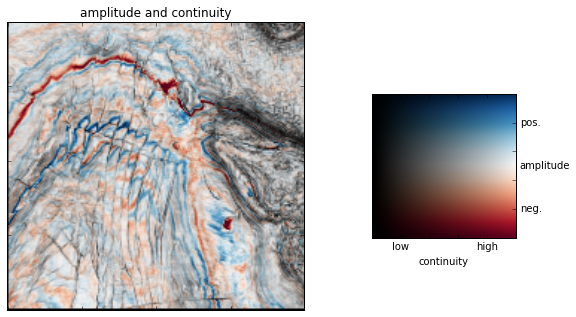

In [32]:
fig = plt.figure(figsize=(10,5), facecolor='white')
ax = fig.add_axes([0.1,0.1,0.5,0.8])
ax.set_title('amplitude and continuity')
ax.imshow(new,  origin='bottom')
ax.set_xticklabels([])
ax.set_yticklabels([])

cax = fig.add_axes([0.6,0.3,0.3,0.4],axisbg='k')
cax.imshow(RGB, origin="lower", extent=[0, 1, 0, 1])
plot_annot(cax, 'amplitude', 'continuity')
fig.show()

fig.savefig('Data_Amp_Cont_2D_colormap.PNG')

Now every value in the image space represents an specific value in the x-y plance of the 2-D colormap legend.

## Non linear opacity scaling correction

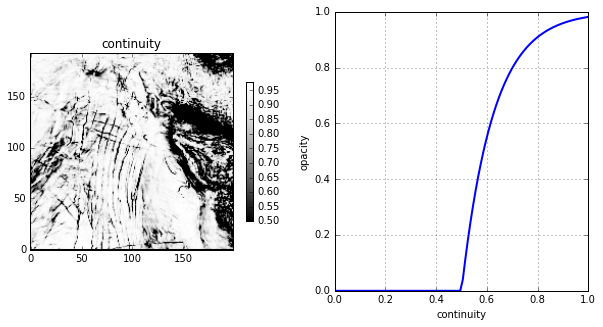

In [30]:
Bstart = 0.5
Bstop = 1.0

power = np.arange(1,6)
base = 10*np.ones(len(power))
c = base**power 
k = 8

def opaque_transform(x, k, Bstart):
    curve = 1-np.exp(-1*k*(x-Bstart)) 
    return np.clip(curve,0.0,1.0)

Bscaled = opaque_transform(B,k,Bstart)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
plt.imshow(Bscaled, cmap='Greys_r',origin='bottom', vmin=Bstart)
plt.colorbar(shrink=0.5)
plt.title('continuity')

ax2 = fig.add_subplot(122)

x = np.linspace(0,1.0,100)
for i in [k]:
    y = opaque_transform(x,i,Bstart)
    ax2.plot(x,y, '-', lw=2)
    ax2.set_xlim([0,1.0])
    ax2.set_ylim([0,1.0])
ax2.grid()
plt.ylabel('opacity')
plt.xlabel('continuity')
fig.show()


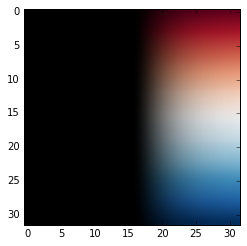

In [26]:
hues, sats = np.mgrid[0:1:32j, 0:1:32j]
Bscbar = opaque_transform(sats,k,Bstart)
opacity = np.expand_dims(Bscbar,-1)
RGBAmap = np.dstack((seis_rgb_mtx,opacity))
fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.5,0.8], axisbg='k')
ax.imshow(RGBAmap)
fig.show()

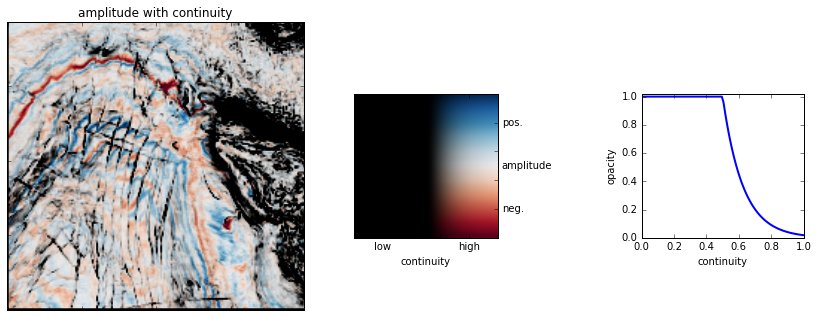

In [37]:
# Modulate alpha with discontinuity
img_array = plt.get_cmap('RdBu')(Anorm)
img_array = img_array[:,:,:3]
# Modulate opacity Continuity
opacity2 = np.expand_dims(Bscaled,-1)
RGBA = np.dstack((img_array,opacity2))

# Make figure (again)
fig = plt.figure(figsize=(15,5), facecolor='w')
ax = fig.add_axes([0.1,0.1,0.3,0.8], axisbg='k')
ax.set_title('amplitude with continuity')
ax.imshow(RGBA,  origin='bottom')
ax.set_xticklabels([])
ax.set_yticklabels([])

cax = fig.add_axes([0.35,0.3,0.3,0.4],axisbg='k')
cax.imshow(RGBAmap, origin="lower", extent=[0, 1, 0, 1])
plot_annot(cax, 'amplitude', 'continuity')
fig.show()

#fig.savefig('Data_Amp_Cont_2D_colormap.PNG')
grax = fig.add_axes([0.7,0.3,0.15,0.4], axisbg='w')
for i in [k]:
    y = opaque_transform(x,i,Bstart)
    grax.plot(x,1-y, '-', lw=2)
    grax.set_xlim([0,1.0])
    grax.set_ylim([0,1.02])
ax2.grid()
plt.ylabel('opacity')
plt.xlabel('continuity')
fig.show()
fig.savefig('Data_Amp_Cont_Sculplted.PNG')
